<a href="https://colab.research.google.com/github/SandhyaKshirsagar/Timeseries/blob/main/Passanger_demand_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Excluding harmless warnings
import warnings
warnings.filterwarnings('ignore')

# Importing required libraries
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, ExponentialSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the data, making the month col as the index
data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/TIme Series/Day 6/passangers_data.csv', index_col='Month', parse_dates=True)
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
# Data dimensions
print(f'The data has {data.shape[0]} rows and {data.shape[1]} column', end='\n\n')

print(data.info())

The data has 144 rows and 1 column

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   #Passengers  144 non-null    int64
dtypes: int64(1)
memory usage: 2.2 KB
None


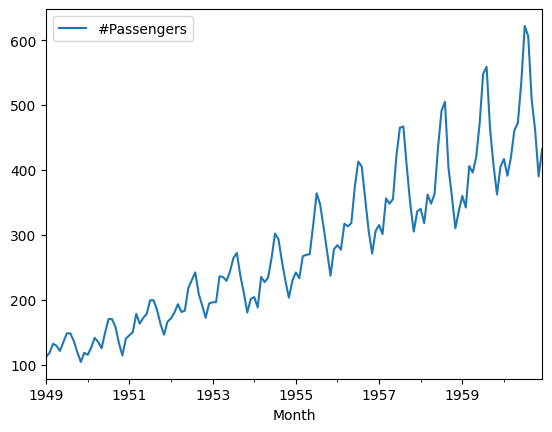

In [ ]:
# Ploting the data
data.plot()
plt.show()

The plot shows that the data has Trend, Seasonality and its non stationary

In [ ]:
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [ ]:
data.index.freq = 'MS'    # hardcoding the frequency to month starting
print(data.index.freq)

<MonthBegin>


In [ ]:
data.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [ ]:
# Data splitting
train = data[:120]
test = data[120:]      # 2-years of prediction

In [ ]:
# Exponential smoothening
# Trying the simple exponential model

def ses_optimizer(train, alphas, step=24):
    best_alpha, best_mae = None, float("inf")
    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_mae = alpha, mae
        print("alpha:", round(alpha, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_mae

alphas = np.arange(0.01, 1, 0.10)
best_alpha, best_mae = ses_optimizer(train, alphas, step=24)
# best_alpha: 0.11 best_mae: 82.528

alpha: 0.01 mae: 225.5863
alpha: 0.11 mae: 82.528
alpha: 0.21 mae: 82.8979
alpha: 0.31 mae: 89.8377


/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)
/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress

alpha: 0.41 mae: 99.0585
alpha: 0.51 mae: 107.5558
alpha: 0.61 mae: 113.7514
alpha: 0.71 mae: 117.2224
alpha: 0.81 mae: 118.1776
alpha: 0.91 mae: 117.2438
best_alpha: 0.11 best_mae: 82.528


/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


/usr/local/lib/python3.10/dist-packages/pandas/util/_decorators.py:213: EstimationWarning: Model has no free parameters to estimate. Set optimized=False to suppress this warning
  return func(*args, **kwargs)


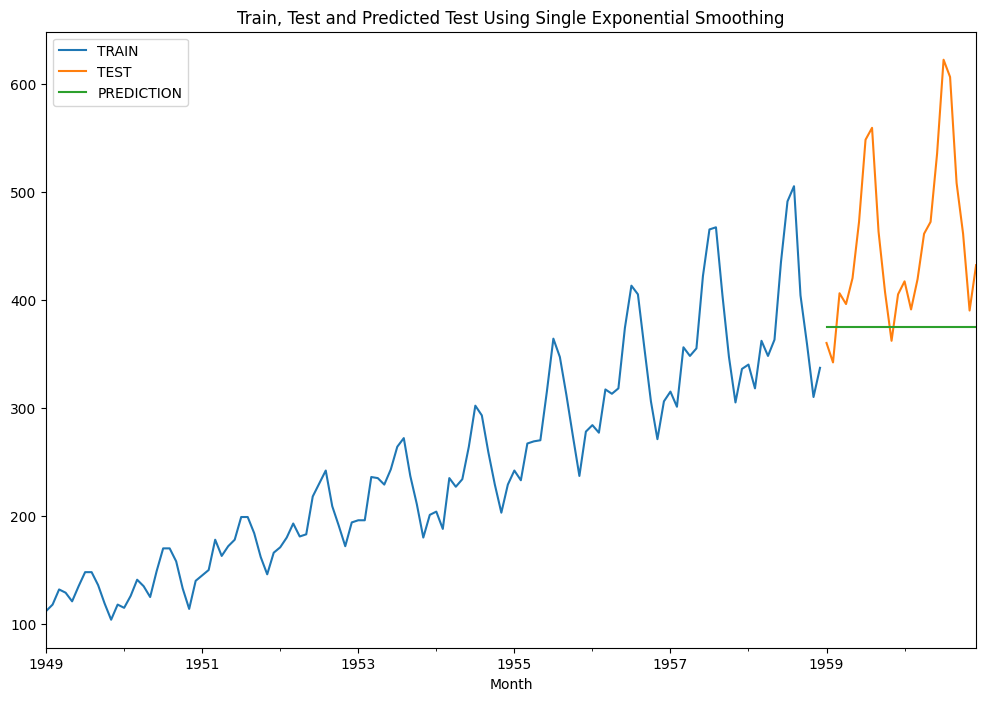

In [ ]:
# Predicting the future data with simple exponential model
ses_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
y_pred = ses_model.forecast(24)

def plot_prediction(y_pred, label):
    plt.figure(figsize=(12,8))
    train["#Passengers"].plot(legend=True, label="TRAIN")
    test["#Passengers"].plot(legend=True, label="TEST")
    y_pred.plot(legend=True, label="PREDICTION")
    plt.title("Train, Test and Predicted Test Using "+label)
    plt.show()

plot_prediction(y_pred, "Single Exponential Smoothing")

The plot shows that the predictions are not correct, this is because the data has trend and seasonality and simple exponential model does not work for data with trend and seasonality.

In [ ]:
# Double explonential smoothening
# Trying Double Exponential model
def des_optimizer(train, alphas, betas, step=48):
    best_alpha, best_beta, best_mae = None, None, float("inf")
    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae
            print("alpha:", round(alpha, 2), "beta:", round(beta, 2), "mae:", round(mae, 4))
    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_mae:", round(best_mae, 4))
    return best_alpha, best_beta, best_mae

alphas = np.arange(0.01, 1, 0.10)
betas = np.arange(0.01, 1, 0.10)

best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, step=24)


alpha: 0.01 beta: 0.01 mae: 54.9512
alpha: 0.01 beta: 0.11 mae: 54.1036
alpha: 0.01 beta: 0.21 mae: 55.5568
alpha: 0.01 beta: 0.31 mae: 57.3247
alpha: 0.01 beta: 0.41 mae: 57.7931
alpha: 0.01 beta: 0.51 mae: 57.9968
alpha: 0.01 beta: 0.61 mae: 57.9637
alpha: 0.01 beta: 0.71 mae: 57.5635
alpha: 0.01 beta: 0.81 mae: 57.3334
alpha: 0.01 beta: 0.91 mae: 57.8983
alpha: 0.11 beta: 0.01 mae: 55.0309
alpha: 0.11 beta: 0.11 mae: 58.4728
alpha: 0.11 beta: 0.21 mae: 69.6339
alpha: 0.11 beta: 0.31 mae: 72.555
alpha: 0.11 beta: 0.41 mae: 78.8168
alpha: 0.11 beta: 0.51 mae: 81.996
alpha: 0.11 beta: 0.61 mae: 77.2262
alpha: 0.11 beta: 0.71 mae: 71.5042
alpha: 0.11 beta: 0.81 mae: 69.0258
alpha: 0.11 beta: 0.91 mae: 67.8408
alpha: 0.21 beta: 0.01 mae: 57.1824
alpha: 0.21 beta: 0.11 mae: 74.992
alpha: 0.21 beta: 0.21 mae: 95.9492
alpha: 0.21 beta: 0.31 mae: 115.3164
alpha: 0.21 beta: 0.41 mae: 139.4303
alpha: 0.21 beta: 0.51 mae: 178.3759
alpha: 0.21 beta: 0.61 mae: 243.4543
alpha: 0.21 beta: 0.71 mae:

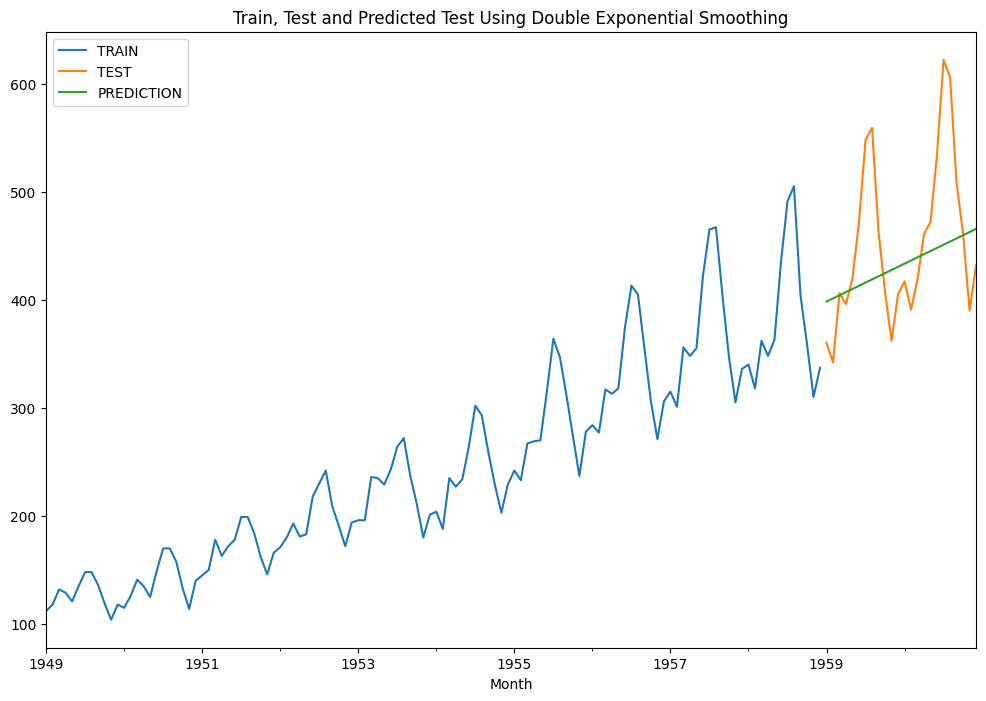

In [ ]:
# Predicting the future values with Double Exponential model
des_model = ExponentialSmoothing(train, trend="add").fit(smoothing_level=best_alpha,
                                                         smoothing_slope=best_beta)
y_pred = des_model.forecast(24)

plot_prediction(y_pred, "Double Exponential Smoothing")

This plot shows that the predicted test data has a trend but there is no seasonality, which is not correct. As the data has trend and seasonality, the double exponential model is not suitable for it.

In [ ]:
# Triple exponential smoothening
# Trying the triple exponential model
def tes_optimizer(train, abg, step=48):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend="add", seasonal="add", seasonal_periods=12).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae
        print([round(comb[0], 2), round(comb[1], 2), round(comb[2], 2), round(mae, 2)])

    print("best_alpha:", round(best_alpha, 2), "best_beta:", round(best_beta, 2), "best_gamma:", round(best_gamma, 2),
          "best_mae:", round(best_mae, 4))

    return best_alpha, best_beta, best_gamma, best_mae

alphas = betas = gammas = np.arange(0.10, 1, 0.20)
abg = list(itertools.product(alphas, betas, gammas))

best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg, step=24)

[0.1, 0.1, 0.1, 36.83]
[0.1, 0.1, 0.3, 34.88]
[0.1, 0.1, 0.5, 35.91]
[0.1, 0.1, 0.7, 38.72]
[0.1, 0.1, 0.9, 42.55]
[0.1, 0.3, 0.1, 53.96]
[0.1, 0.3, 0.3, 53.0]
[0.1, 0.3, 0.5, 56.98]
[0.1, 0.3, 0.7, 61.38]
[0.1, 0.3, 0.9, 67.17]
[0.1, 0.5, 0.1, 56.76]
[0.1, 0.5, 0.3, 51.72]
[0.1, 0.5, 0.5, 53.39]
[0.1, 0.5, 0.7, 60.08]
[0.1, 0.5, 0.9, 79.29]
[0.1, 0.7, 0.1, 34.04]
[0.1, 0.7, 0.3, 25.93]
[0.1, 0.7, 0.5, 27.81]
[0.1, 0.7, 0.7, 27.91]
[0.1, 0.7, 0.9, 38.32]
[0.1, 0.9, 0.1, 26.87]
[0.1, 0.9, 0.3, 25.32]
[0.1, 0.9, 0.5, 53.88]
[0.1, 0.9, 0.7, 38.38]
[0.1, 0.9, 0.9, 17.78]
[0.3, 0.1, 0.1, 54.54]
[0.3, 0.1, 0.3, 38.34]
[0.3, 0.1, 0.5, 31.57]
[0.3, 0.1, 0.7, 30.99]
[0.3, 0.1, 0.9, 29.23]
[0.3, 0.3, 0.1, 72.71]
[0.3, 0.3, 0.3, 22.6]
[0.3, 0.3, 0.5, 11.99]
[0.3, 0.3, 0.7, 17.11]
[0.3, 0.3, 0.9, 22.32]
[0.3, 0.5, 0.1, 132.33]
[0.3, 0.5, 0.3, 25.74]
[0.3, 0.5, 0.5, 17.3]
[0.3, 0.5, 0.7, 38.38]
[0.3, 0.5, 0.9, 56.82]
[0.3, 0.7, 0.1, 288.32]
[0.3, 0.7, 0.3, 134.86]
[0.3, 0.7, 0.5, 96.77]
[0.3, 0.7, 

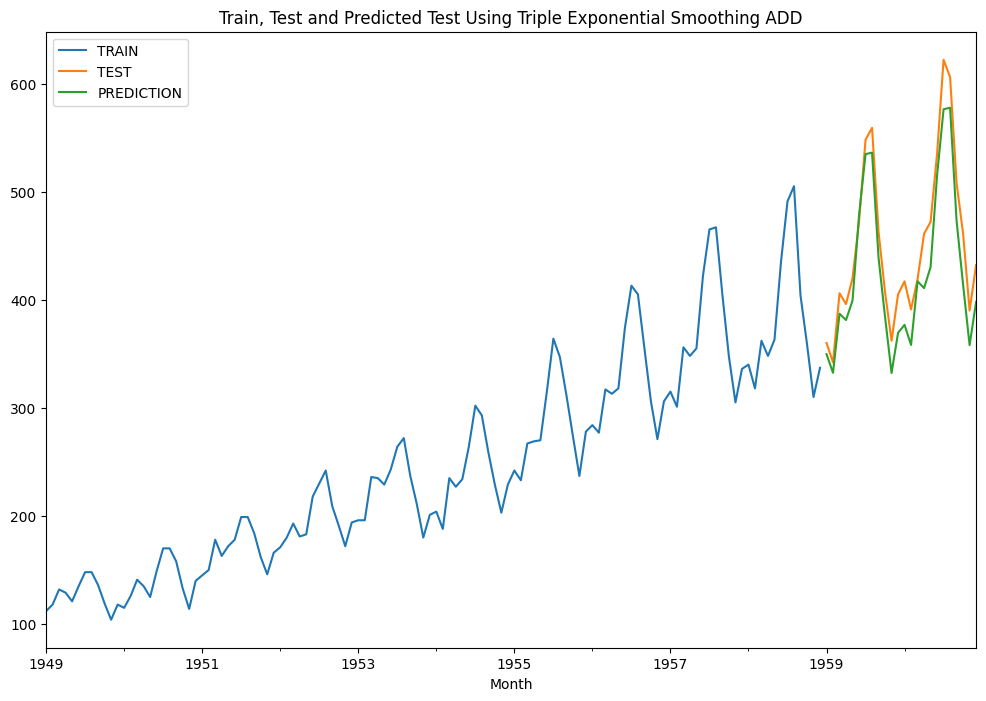

In [ ]:
# Predicting the future values with triple exponential model
tes_model = ExponentialSmoothing(train, trend="mul", seasonal="mul", seasonal_periods=12).\
            fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)

y_pred = tes_model.forecast(24)

plot_prediction(y_pred, "Triple Exponential Smoothing ADD")

The plot shows that the predicted test data has the similar trend and seasonality as the training data.

[0, 0, 0, 1436.33]
[0, 0, 1, 1295.42]
[0, 0, 2, 1229.22]
[0, 0, 3, 1169.78]
[0, 0, 4, 1191.75]
[0, 0, 5, 1145.7]
[0, 1, 0, 1138.81]
[0, 1, 1, 1127.02]
[0, 1, 2, 1126.97]
[0, 1, 3, 1125.45]
[0, 1, 4, 1107.49]
[0, 1, 5, 1105.75]
[0, 2, 0, 1171.65]
[0, 2, 1, 1136.52]
[0, 2, 2, 1124.36]
[0, 2, 3, 1124.57]
[0, 2, 4, 1114.69]
[0, 2, 5, 1101.67]
[0, 3, 0, 1263.95]
[0, 3, 1, 1169.49]
[0, 3, 2, 1140.39]
[0, 3, 3, 1127.31]
[0, 3, 4, 1128.09]
[0, 3, 5, 1123.42]
[0, 4, 0, 1380.24]
[0, 4, 1, 1260.84]
[0, 4, 2, 1171.98]
[0, 4, 3, 1148.8]
[0, 4, 4, 1134.65]
[0, 4, 5, 1135.91]
[0, 5, 0, 1504.35]
[0, 5, 1, 1375.62]
[0, 5, 2, 1261.41]
[0, 5, 3, 1230.64]
[0, 5, 4, 1229.16]
[0, 5, 5, 1284.65]
[1, 0, 0, 1152.4]
[1, 0, 1, 1138.85]
[1, 0, 2, 1140.24]
[1, 0, 3, 1142.18]
[1, 0, 4, 1123.69]
[1, 0, 5, 1121.98]
[1, 1, 0, 1130.66]
[1, 1, 1, 1125.43]
[1, 1, 2, 1118.1]
[1, 1, 3, 1119.79]
[1, 1, 4, 1109.36]
[1, 1, 5, 1091.25]
[1, 2, 0, 1168.21]
[1, 2, 1, 1127.97]
[1, 2, 2, 1122.89]
[1, 2, 3, 1123.66]
[1, 2, 4, 1125.6

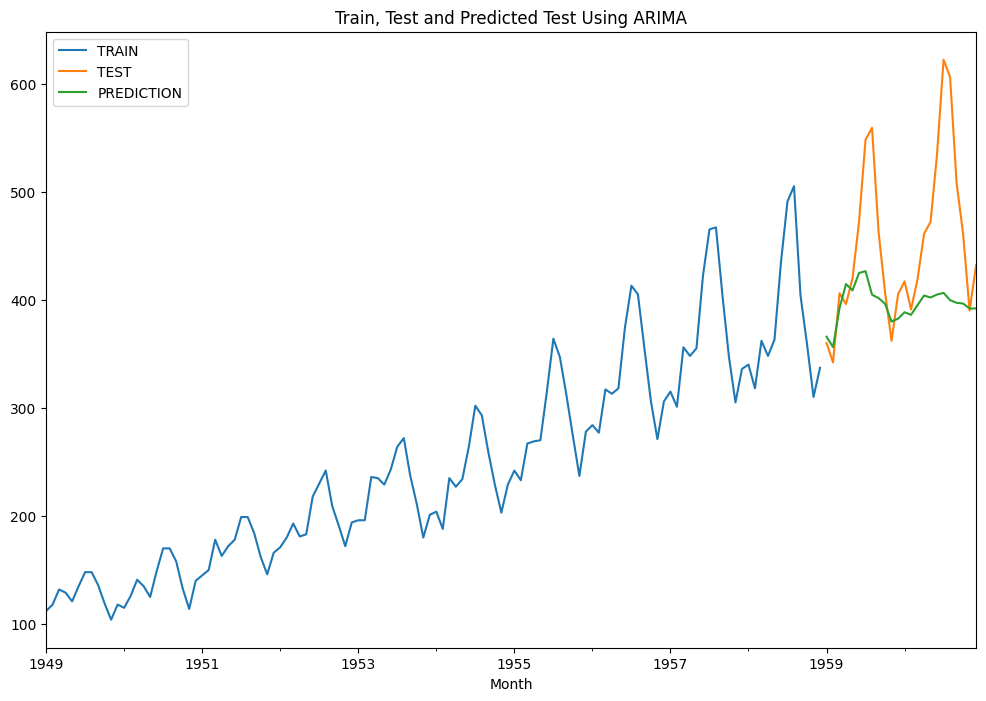

In [ ]:
# ARIMA model
def arima_optimizer(train, p, d, q, step=24):
    # p - order for ar model (pacf lags)
    # d - d is order for intergration
    # q - order for ma model (acf lags)
    warnings.filterwarnings('ignore')
    best_p, best_d, best_q, best_aic = None, None, None, float("inf")
    for param in itertools.product(p, d, q):
        try:
            arima_model = ARIMA(train, order=param).fit()
            y_pred = arima_model.forecast(step)
            aic = arima_model.aic
            if aic < best_aic:
                best_p, best_d, best_q, best_aic = param[0], param[1], param[2], aic
            print([param[0], param[1], param[2], round(aic, 2)])
        except:
            continue
    print("best_p:", best_p, "best_d:", best_d, "best_q:", best_q, "best_aic:", round(best_aic, 2))
    return best_p, best_d, best_q, best_aic

p = range(0, 6)
d = range(0, 6)
q = range(0, 6)

best_p, best_d, best_q, best_aic = arima_optimizer(train, p, d, q, step=24)

arima_model = ARIMA(train, order=(best_p, best_d, best_q)).fit()
y_pred = arima_model.forecast(24)

plot_prediction(y_pred, "ARIMA")

Prediction done using ARIMA model shows trend and seasonality but it does not match the training data trend and seasonality. ARIMA model works better when the data is stationary, here as the data is not stationary, we can see a lot of difference between the training and the test data predicitons.

In [ ]:
# Checking the data stationarity using the ADF test.
from statsmodels.tsa.stattools import adfuller

def check_stationarity(timeseries):
    # Perform the Augmented Dickey-Fuller test
    result = adfuller(timeseries)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

    if result[1] <= 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

# Check stationarity of the original data
check_stationarity(data['#Passengers'])

ADF Statistic: 0.8153688792060498
p-value: 0.991880243437641
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598
The time series is not stationary.


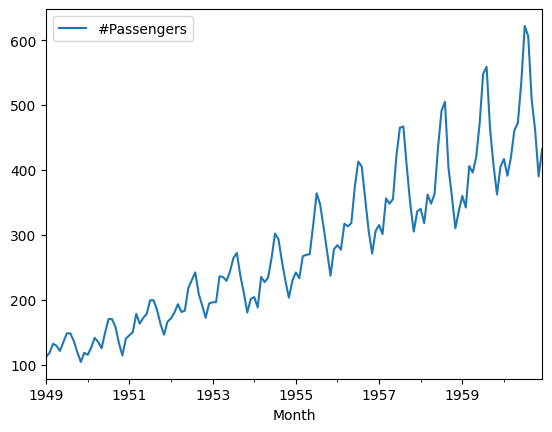

In [ ]:
# Ploting the data
data.plot()
plt.show()

Using the Lag / Differencing method to make the data stationary

In [ ]:
# 12 - Seasonality differencing
data['Passenger 12 diff'] = data['#Passengers'] - data['#Passengers'].shift(12)

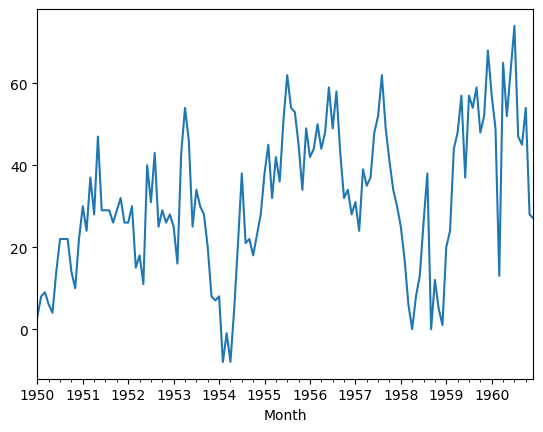

In [ ]:
# Ploting the data
data['Passenger 12 diff'].dropna().plot()
plt.show()

In [ ]:
# Check stationarity of the differenced data
check_stationarity(data['Passenger 12 diff'].dropna())

ADF Statistic: -3.383020726492481
p-value: 0.011551493085514952
Critical Values:
	1%: -3.4816817173418295
	5%: -2.8840418343195267
	10%: -2.578770059171598
The time series is stationary.
